In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=2989381438b170b7b62f2b1707776e51720e2801d04d1cc8a375b152e1501be7
  Stored in directory: c:\users\sienna\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor
Note: you may need to restart the kernel to use updated packages.


# week 4 삼성전자 주식, 이더리움 시세 인공지능으로 예측해보기

### LSTM(Long Short Term Memory)
1) 인공지능 모델이 기억을 가지고 있다.<br>
2) 이전 데이터를 가지고 이후의 데이터를 예측하는 인공지능 모델<br>
예) 최근 50일 간의 주식가격 데이터를 바탕으로 내일 주식가격을 예측<br><br>
3) 인공지능이 기억력을 가지고 예측할 수 있다는 것이 장점<br>
예) 주식가격, 암호화폐 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# Load Dataset

- Dataset<br>
Yahoo Finance: https://finance.yahoo.com<br>
Samsung Electronics Co., Ltd. (005930.KS)<br>
Historical Data > Time Period - 5Y(5년) > Download Data

In [8]:
data = pd.read_csv('dataset/005930.KS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-07,39560.0,39580.0,38760.0,38820.0,33687.878906,14041800
1,2017-02-08,38740.0,38780.0,38200.0,38400.0,33323.406250,17092950
2,2017-02-09,38780.0,38840.0,38220.0,38400.0,33323.406250,13694150
3,2017-02-10,38400.0,38760.0,38300.0,38360.0,33288.695313,11020750
4,2017-02-13,37740.0,38060.0,37720.0,37960.0,32941.574219,11102050


# Compute Mid Price

In [9]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2        # 중간값을 mid_prices에 저장

# Create Windows

In [10]:
#최근 50일 간의 데이터를 보고 내일 데이터를 예측한다

seq_len = 50                    # window 사이즈 지정 (최근 몇 일의 데이터를 볼 것인가)
sequence_length =  seq_len + 1  # 예측값 하나를 더하여 총 51개가 되도록 한다

result = []                     # 한 칸씩 밀려가면서 리스트에 저장
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

![window1](img/window1.png)

window에 들어가는 데이터 갯수는 총 51개 (50일간의 데이터+예측할 값 1)

![window2](img/window2.png)

그 다음 window는 한 칸씩 밀려나면서 생성<br>
1) 빨간네모 : 첫 번째 window<br>
2) 노란네모 : 두 번째 window<br>
3) 초록네모 : 세 번째 window<br>

# Normalize Data

In [11]:
# 정규화 : window의 값들을 싹 훑으면서 각 값의 첫 번째 값을 나눠준 다음 1을 뺀다.

normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)



# split train and test data (9:1)
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)    # 배열의 값을 랜덤으로 섞는다

x_train = train[:, :-1]     # x_train에 50개의 데이터
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]      # y_train에 1개의 데이터

x_test = result[row:, :-1]  # x_test에 50개의 데이터
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]   # y_test에 1개의 데이터

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

1057개의 trainig set, 117개의 test set<br>
→ 1057일의 데이터를 가지고 학습해서 117일의 주식 가격을 예측 할 것이다

# Build a Model

In [12]:
model = Sequential()    # 모델을 순차적으로 정의하는 클래스

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))    # LSTM 레이어

model.add(LSTM(64, return_sequences=False))    # model.add() 모델에 레이어를 추가한다

model.add(Dense(1, activation='linear'))        # fully connected layer

model.compile(loss='mse', optimizer='rmsprop')  # mse = Mean Squared Error

model.summary()                                 # 모델의 개요를 출력한다

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [13]:
# 모델을 학습시킨다
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

Epoch 1/20
106/106 [==============================] - 12s 60ms/step - loss: 0.0020 - val_loss: 6.7784e-04
Epoch 2/20
106/106 [==============================] - 5s 48ms/step - loss: 0.0010 - val_loss: 5.2472e-04
Epoch 3/20
106/106 [==============================] - 5s 48ms/step - loss: 7.5448e-04 - val_loss: 3.2477e-04
Epoch 4/20
106/106 [==============================] - 5s 48ms/step - loss: 5.6964e-04 - val_loss: 4.1008e-04
Epoch 5/20
106/106 [==============================] - 5s 48ms/step - loss: 5.2631e-04 - val_loss: 2.0638e-04
Epoch 6/20
106/106 [==============================] - 5s 48ms/step - loss: 3.9018e-04 - val_loss: 1.9208e-04
Epoch 7/20
106/106 [==============================] - 5s 48ms/step - loss: 3.6649e-04 - val_loss: 1.6203e-04
Epoch 8/20
106/106 [==============================] - 5s 48ms/step - loss: 3.4274e-04 - val_loss: 1.7087e-04
Epoch 9/20
106/106 [==============================] - 5s 47ms/step - loss: 3.1125e-04 - val_loss: 1.2658e-04
Epoch 10/20
106/106 [=====

→ val_loss가 작을 수록 학습이 잘 된다는 증거

![batch](img/batch.png)

batch = 한 번에 몇 개씩 묶어서 학습시킬 거냐<br>
epochs = 20번 동안 반복학습

# Prediction

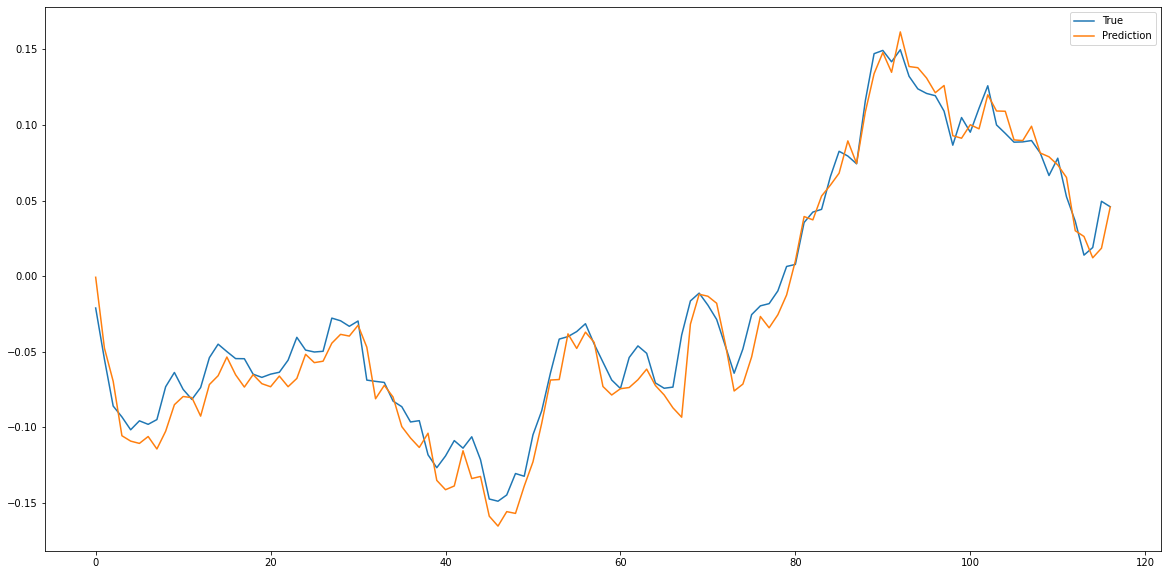

In [14]:
# 모델을 사용하여 test데이터를 예측한다.
# 예측한 결과값을 pred 변수에 저장
pred = model.predict(x_test)

#그래프 그리기
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

파란색 : 실제 데이터<br>
주황색 : 예측 데이터